## Imports


In [3]:
from dataloader import GScan_Images
from model import MuonClassifier

from torch.utils.data import Dataset, random_split, DataLoader,ConcatDataset
import torch
from torch.nn import BCELoss

from tqdm import tqdm


import wandb
import random
from datetime import datetime

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# import urllib.request
import requests

# from sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay




import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

## Getting model output

### Data

In [5]:
BATCH_SIZE=4
num_workers=8



train_data=GScan_Images('./data_classification_loose/train/')
val_data=GScan_Images('./data_classification_loose/test/')

# DataLoader for training and validation sets
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model= MuonClassifier()
# model = BB_model()
model.load_state_dict(torch.load('weights/cnn1_2024-09-22_19-07-20.pth'))
model.to(device=device)


loss=BCELoss()
# loss=CustomMaskedMSELoss()
# eval_iou=CustomIOU()

cuda


### Predicting


In [7]:
all_labels = []
all_outputs = []
all_front_images = []
all_side_images = []

with torch.no_grad():
    for i, data in enumerate(tqdm(val_dataloader)):
        front = data['front'].to(device=device) 
        side = data['side'].to(device=device)
        label = data['label'].to(device=device)

        output = model(front, side).squeeze(1)

        all_labels.append(label)
        all_outputs.append(output)
        
        # Collect front and side images
        all_front_images.append(front.cpu())  # Moving to CPU for easier access if needed
        all_side_images.append(side.cpu())

        val_loss = loss(output, label)

# Concatenate labels and outputs
all_labels = torch.cat(all_labels, dim=0)
all_outputs = torch.cat(all_outputs, dim=0)

# Optionally concatenate the front and side images if needed
# all_front_images = torch.cat(all_front_images, dim=0)
# all_side_images = torch.cat(all_side_images, dim=0)


100%|██████████| 74/74 [00:20<00:00,  3.68it/s]


In [8]:
all_labels.shape


torch.Size([293])

In [9]:
all_outputs.shape

torch.Size([293])

### Confusion matrix

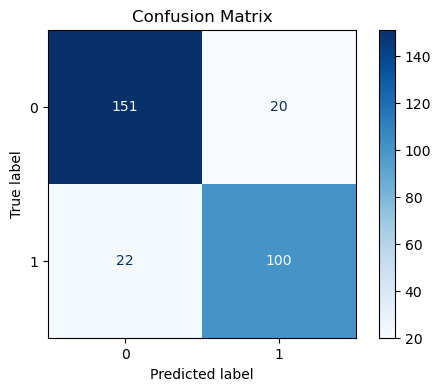

Selected Threshold: 0.45
Accuracy: 0.86
Precision: 0.83
Recall: 0.82
F1 Score: 0.83


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Assuming `all_labels` and `all_outputs` contain the true labels and model predictions
y_true = all_labels.cpu().numpy()
y_pred_prob = all_outputs.cpu().numpy()

# Set up the candidate thresholds
candidate_thresholds = np.linspace(0.0, 1.0, 100)  # Generates 100 thresholds between 0 and 1

# Variables to store the best F1 score and corresponding threshold
best_f1 = 0
selected_threshold = 0
pred = []

for threshold in candidate_thresholds:
    # Convert probabilities to binary predictions using the threshold
    pred_current = [1 if i >= threshold else 0 for i in y_pred_prob]
    
    # Calculate F1 score for the current threshold
    f1 = f1_score(y_true, pred_current)
    
    # If this F1 score is the best, store it and update the selected threshold
    if f1 > best_f1:
        best_f1 = f1
        selected_threshold = threshold
        pred = pred_current

# Display the confusion matrix for the selected threshold
cm = confusion_matrix(y_true, pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap='Blues', values_format='d')

# Set title and show plot
plt.title(f"Confusion Matrix")
plt.show()

# Calculate accuracy, precision, recall, and F1 score for the selected threshold
accuracy = accuracy_score(y_true, pred)
precision = precision_score(y_true, pred)
recall = recall_score(y_true, pred)
f1 = f1_score(y_true, pred)

print(f"Selected Threshold: {selected_threshold:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


### ROC curve and AUC score

AUC Score: 0.9275237273511648


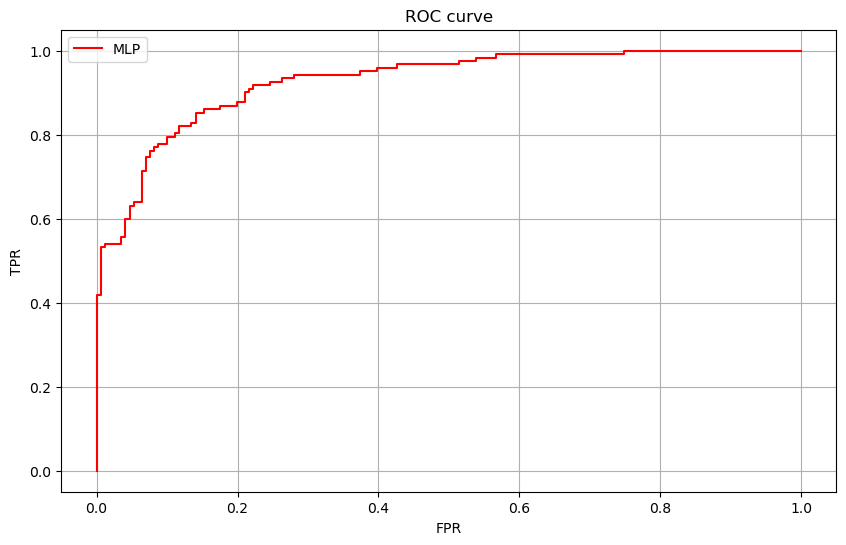

In [11]:
auc = roc_auc_score(y_true,y_pred_prob)


print("AUC Score:",auc)


fpr, tpr, thresholds = roc_curve(y_true,y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="MLP", color="red")
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.legend(loc="best")
plt.show()


In [12]:
all_labels_np = all_labels.cpu().numpy()
all_outputs_np = all_outputs.cpu().numpy()
all_front_images_np = torch.cat(all_front_images, dim=0).cpu().numpy()
all_side_images_np = torch.cat(all_side_images, dim=0).cpu().numpy()

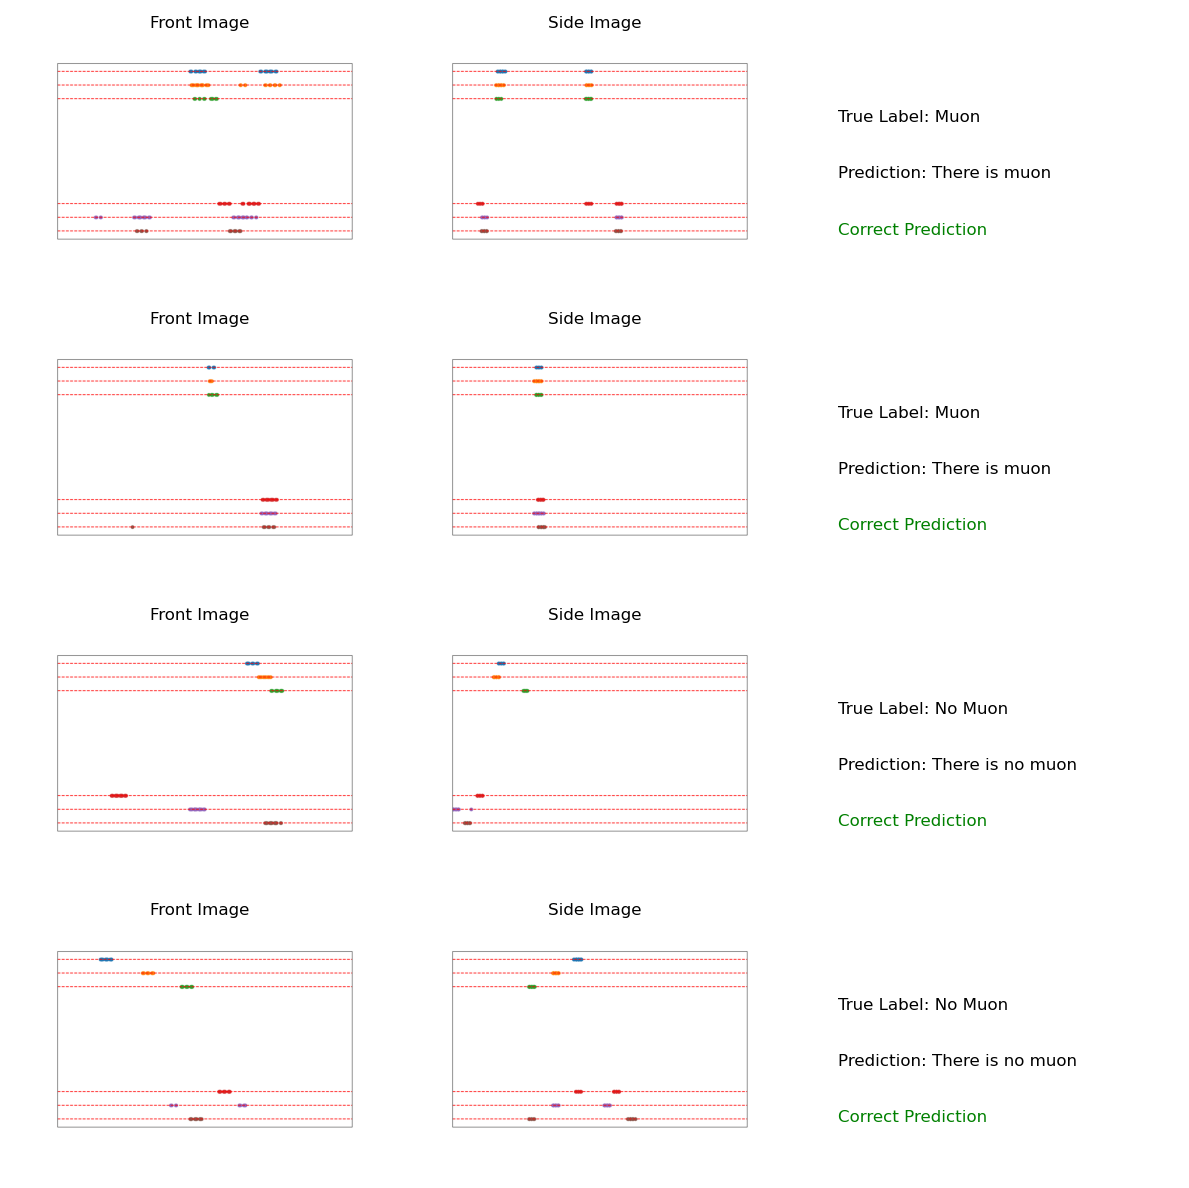

In [13]:
# Assuming you want to visualize 5 random samples
num_samples = 4
fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))

# Convert labels and outputs to CPU and numpy for easier handling


# Get random indices to visualize
random_indices = np.random.choice(len(all_labels_np), size=num_samples, replace=False)

for i, idx in enumerate(random_indices):
    front_img = all_front_images_np[idx].transpose(1, 2, 0)  # reshape for display if needed
    side_img = all_side_images_np[idx].transpose(1, 2, 0)
    true_label = all_labels_np[idx]
    prediction = all_outputs_np[idx]
    
    # Determine if prediction meets threshold for "muon presence"
    predicted_label = "There is muon" if prediction >= selected_threshold else "There is no muon"
    
    # Check if the prediction is correct
    correct_prediction = "Correct Prediction" if (prediction >= selected_threshold) == (true_label == 1) else "Incorrect Prediction"

    # Display front image
    axes[i, 0].imshow(front_img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Front Image")
    
    # Display side image
    axes[i, 1].imshow(side_img)
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Side Image")
    
    # Display true label, predicted label, and correctness
    axes[i, 2].text(0.1, 0.6, f"True Label: {'Muon' if true_label == 1 else 'No Muon'}", fontsize=12)
    axes[i, 2].text(0.1, 0.4, f"Prediction: {predicted_label}", fontsize=12)
    axes[i, 2].text(0.1, 0.2, correct_prediction, fontsize=12, color="green" if "Correct" in correct_prediction else "red")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()